In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#set size plot
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
#read file
M42 = fits.open('data/frame-u-006073-4-0063.fits')

In [3]:
M42.info()

Filename: data/frame-u-006073-4-0063.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


In [4]:
M42[0].header

SIMPLE  =                    T /                                                
BITPIX  =                  -32 / 32 bit floating point                          
NAXIS   =                    2                                                  
NAXIS1  =                 2048                                                  
NAXIS2  =                 1489                                                  
EXTEND  =                    T /Extensions may be present                       
BZERO   =              0.00000 /Set by MRD_SCALE                                
BSCALE  =              1.00000 /Set by MRD_SCALE                                
TAI     =        4649973257.37 / 1st row Number of seconds since Nov 17 1858    
RA      =            83.820000 / 1st row RA of telescope boresight (deg)        
DEC     =           -5.349071  / 1st row Dec of telescope boresight (degrees)   
SPA     =             180.000  / 1st row Cam col position angle wrt N (deg)     
IPA     =             137.18

In [5]:
#Get data
data = M42[0].data
print(f'Data type: {type(data)}, shape: {data.shape}')

Data type: <class 'numpy.ndarray'>, shape: (1489, 2048)


In [6]:
print(f'Min: {np.min(data)}')
print(f'Max: {np.max(data)}')
print(f'Mean: {np.mean(data)}')
print(f'Stdev: {np.std(data)}')

Min: -0.3447265625
Max: 552.0
Mean: 5.339874744415283
Stdev: 15.16415023803711


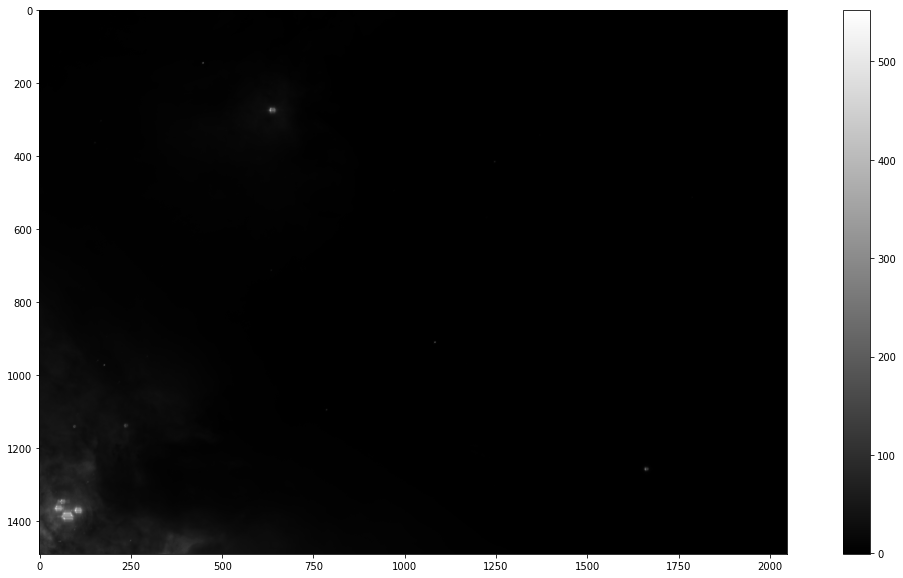

In [8]:
#show image im gray color
plt.imshow(data, cmap='gray')
plt.colorbar()

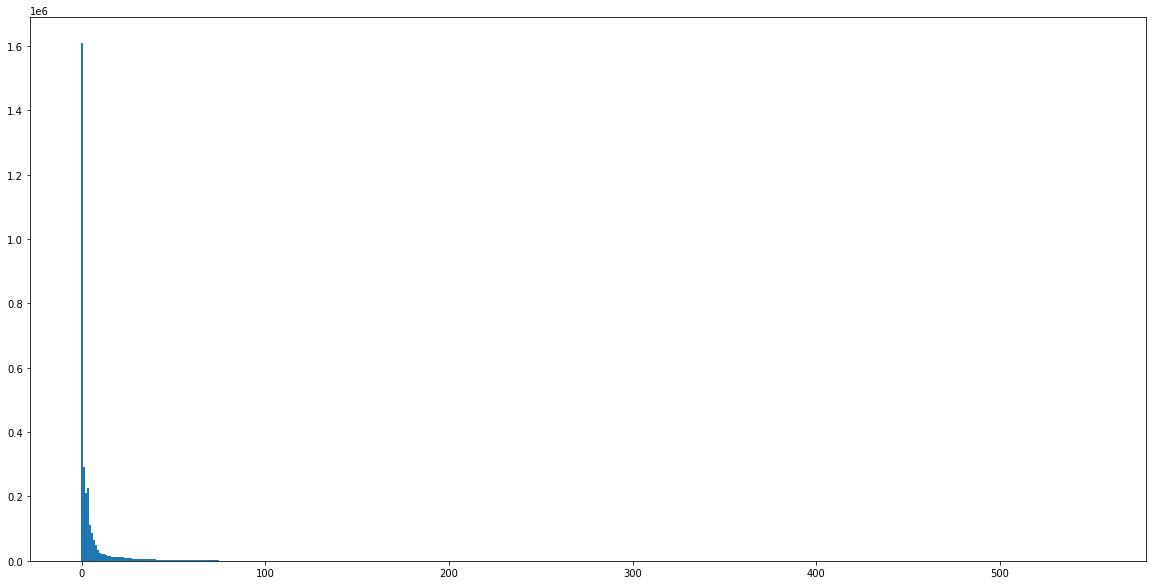

In [9]:
#plot histogram
histogram = plt.hist(data.flat, bins=500)

[Text(1, 5000.0, '5,000'),
 Text(1, 10000.0, '10,000'),
 Text(1, 20000.0, '20,000')]

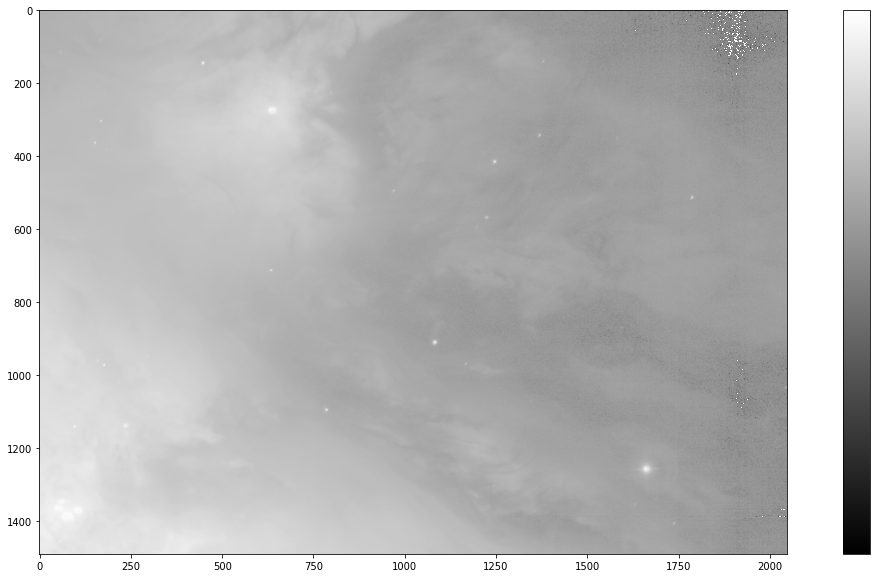

In [10]:
from matplotlib.colors import LogNorm

plt.imshow(data, cmap='gray', norm=LogNorm())
cbar = plt.colorbar(ticks=[5.e3, 1.e4, 2.e4])
cbar.ax.set_yticklabels(['5,000', '10,000', '20,000'])

In [11]:
#RGB color image
from astropy.visualization import make_lupton_rgb

In [12]:
M42u = fits.open('data/frame-u-006073-4-0063.fits')
M42g = fits.open('data/frame-g-006073-4-0063.fits')
M42i = fits.open('data/frame-i-006073-4-0063.fits')

In [13]:
u = M42u[0].data
g = M42g[0].data
i = M42i[0].data

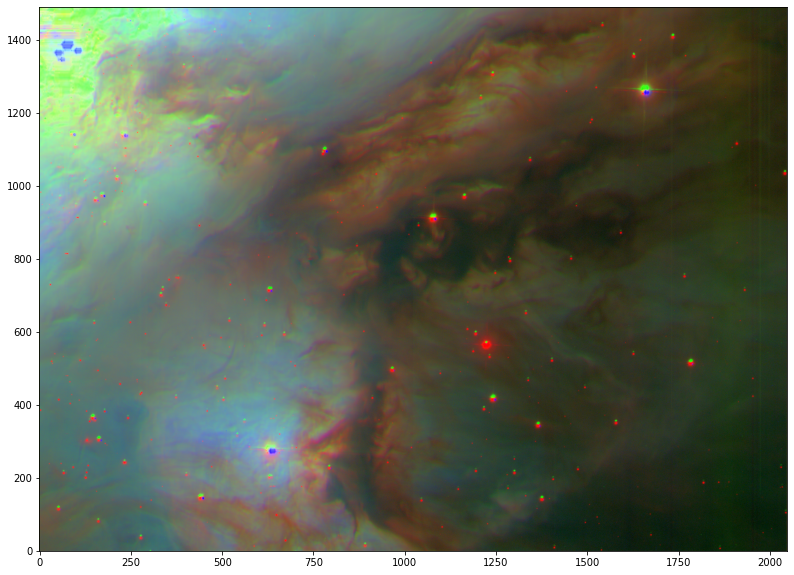

In [14]:
rgb_image = make_lupton_rgb(i, g, u, stretch=1.5, Q=10)
plt.imshow(rgb_image, origin='lower')
plt.savefig('img/rbgM42.jpg')

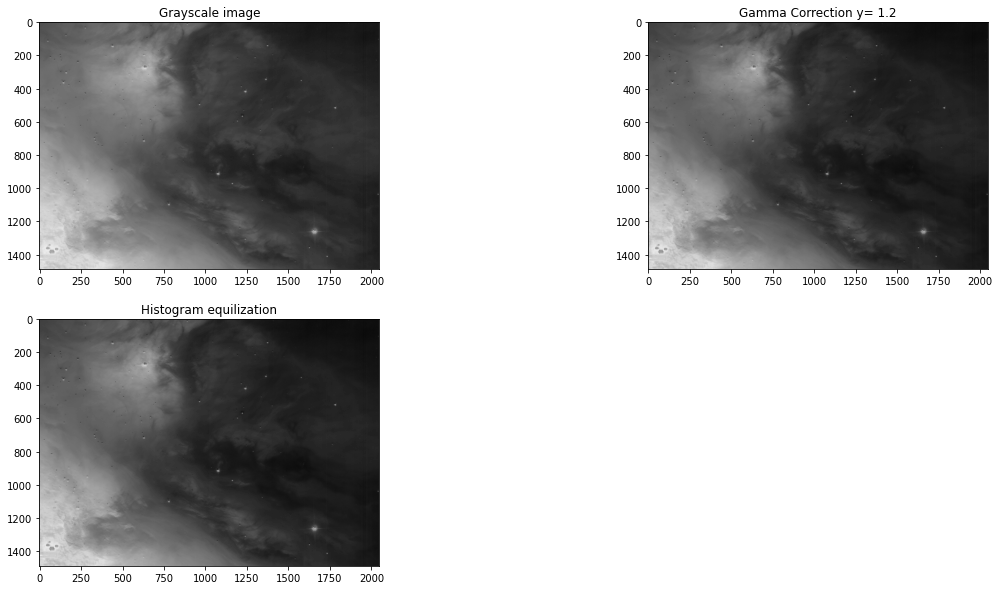

In [27]:
import cv2

gray_im = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
plt.subplot(221)
plt.title('Grayscale image')
plt.imshow(gray_im, cmap="gray", vmin=0, vmax=255)

# Contrast adjusting with gamma correction y = 1.2

gray_correct = np.array(255 * (gray_im / 255) ** 1.2 , dtype='uint8')
plt.subplot(222)
plt.title('Gamma Correction y= 1.2')
plt.imshow(gray_correct, cmap="gray", vmin=0, vmax=255)
# Contrast adjusting with histogramm equalization
gray_equ = cv2.equalizeHist(gray_im)
plt.subplot(223)
plt.title('Histogram equilization')
plt.imshow(gray_correct, cmap="gray", vmin=0, vmax=255)

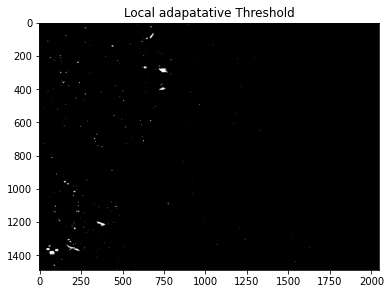

In [28]:
thresh = cv2.adaptiveThreshold(gray_correct, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 19)
thresh = cv2.bitwise_not(thresh)
plt.subplot(221)
plt.title('Local adapatative Threshold')
plt.imshow(thresh, cmap="gray", vmin=0, vmax=255)

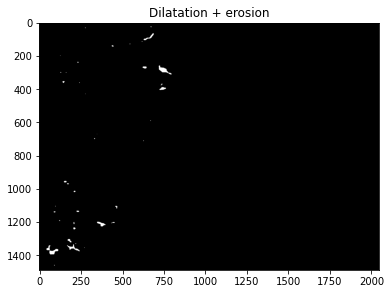

In [30]:
kernel = np.ones((15,15), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
img_erode = cv2.erode(img_dilation,kernel, iterations=1)
# clean all noise after dilatation and erosion
img_erode = cv2.medianBlur(img_erode, 7)
plt.subplot(221)
plt.title('Dilatation + erosion')
plt.imshow(img_erode, cmap="gray", vmin=0, vmax=255)

objects number is: 42


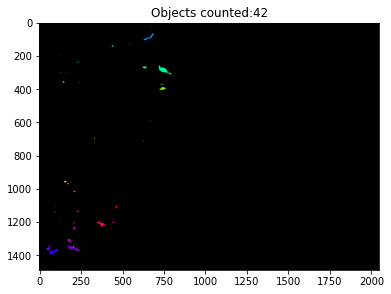

In [31]:
ret, labels = cv2.connectedComponents(img_erode)
label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0

plt.subplot(222)
plt.title('Objects counted:'+ str(ret-1))
plt.imshow(labeled_img)
print('objects number is:', ret-1)
plt.show()